In [1]:
from __future__ import annotations

import os
import sys

import numpy as np
import pandas as pd
# import matplotlib.pyplot as plt
# import path
from pathlib import Path


sys.path.append("..")
# from src.sun_topicmodel.snmf import SNMF
# from src.sun_topicmodel.suntopic import suntopic

from sun_topicmodel import SNMF
from sun_topicmodel import suntopic

# Test SNMF class

In [2]:
np.random.seed(0)
X = np.random.rand(10, 5)
Y = np.random.rand(10)
alpha = 0.5

X_test = np.random.rand(5, 5)
Y_test = np.random.rand(5)
# X_tilde = np.hstack((X, Y.reshape(-1,1)))
X_tilde =  np.hstack(
            (np.sqrt(alpha) * X, np.sqrt(1 - alpha) * np.array(Y).reshape(-1, 1))
        )

snmf_test = SNMF(X_tilde, num_bases=3, random_state=0)
snmf_test.factorize(niter=0)
snmf_test.W, snmf_test.H

(array([[0.2, 1.2, 0.2],
        [1.2, 0.2, 0.2],
        [0.2, 0.2, 1.2],
        [1.2, 0.2, 0.2],
        [0.2, 0.2, 1.2],
        [1.2, 0.2, 0.2],
        [0.2, 0.2, 1.2],
        [1.2, 0.2, 0.2],
        [0.2, 1.2, 0.2],
        [0.2, 1.2, 0.2]]),
 array([[0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.]]))

# Test sunmodel class

In [4]:
model = suntopic(X=X, Y=Y, alpha=0.5,  num_bases=3, random_state=0)
model.fit(niter=0)
model.get_topics(), model.get_coefficients()

(array([[0.2, 1.2, 0.2],
        [1.2, 0.2, 0.2],
        [0.2, 0.2, 1.2],
        [1.2, 0.2, 0.2],
        [0.2, 0.2, 1.2],
        [1.2, 0.2, 0.2],
        [0.2, 0.2, 1.2],
        [1.2, 0.2, 0.2],
        [0.2, 1.2, 0.2],
        [0.2, 1.2, 0.2]]),
 array([[0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.]]))

In [5]:
model.model.W

array([[0.2, 1.2, 0.2],
       [1.2, 0.2, 0.2],
       [0.2, 0.2, 1.2],
       [1.2, 0.2, 0.2],
       [0.2, 0.2, 1.2],
       [1.2, 0.2, 0.2],
       [0.2, 0.2, 1.2],
       [1.2, 0.2, 0.2],
       [0.2, 1.2, 0.2],
       [0.2, 1.2, 0.2]])

In [7]:
model.get_topics() == snmf_test.W, model.get_coefficients() == snmf_test.H

(array([[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True]]),
 array([[ True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True]]))

# Test predict method using SNMF

In [8]:
from sklearn.model_selection import KFold
cv_folds = 2
random_state = 0
num_bases = 3
alpha = 0.5

kf = KFold(n_splits=cv_folds, random_state=random_state, shuffle=True)

X_tilde = np.hstack(((alpha ** 0.5) * X, ((1 - alpha) ** 0.5) * np.array(Y).reshape(-1, 1)))

kfold = kf.split(X=X_tilde)

for k, (train, test) in enumerate(kfold):
    snmf_mdl = SNMF(np.array(X_tilde[train, :]), num_bases=num_bases, random_state=random_state)
    snmf_mdl.factorize(niter=10)
    W_snmf = snmf_mdl.W
    H_snmf = snmf_mdl.H

    beta = H_snmf[:, -1]
    snmf_pred = SNMF(np.array(X_tilde[test, :-1]), num_bases=num_bases, random_state=random_state)
    snmf_pred.H = H_snmf[:,:]
    snmf_pred.factorize(niter=10,
                            compute_h=False, compute_w=True, compute_err=False)
    pred_latent = snmf_pred.W
    pred_response = np.dot(pred_latent, beta)
    Y_pred = pred_response  * ((1 - alpha) ** (-0.5))
    mse = np.mean((Y_pred - Y[test]) ** 2)
    # pred_response = np.dot(pred_latent, beta)
pred_latent, Y_pred, mse


(array([[0.79599726, 0.24618489, 0.59632937],
        [1.06924471, 0.28702082, 0.23303979],
        [0.91749457, 0.33809355, 0.38514903],
        [0.0676815 , 0.50142732, 0.29950645],
        [0.84250319, 0.38035933, 0.66189169]]),
 array([0.32324575, 0.38433793, 0.39015752, 0.31166802, 0.41160046]),
 0.06693775896379821)

# Test predict method using suntopic

In [6]:
cv_folds = 2
random_state = 0
num_bases = 3
alpha = 0.5

kf = KFold(n_splits=cv_folds, random_state=random_state, shuffle=True)

X_tilde = np.hstack(((alpha ** 0.5) * X, ((1 - alpha) ** 0.5) * np.array(Y).reshape(-1, 1)))

kfold = kf.split(X=X_tilde)

model = suntopic(X=X[train,:], Y=Y[train], alpha=0.5,  num_bases=num_bases, random_state=random_state)
model.fit(niter=10)
model.get_topics(), model.get_coefficients()

Y_pred, topics_pred = model.predict(X[test,:], return_topics=True, random_state=0,
                                    niter=10, compute_err=False)

mse = np.mean((Y[test] - Y_pred) ** 2)
topics_pred, Y_pred, mse


(array([[0.79599726, 0.24618489, 0.59632937],
        [1.06924471, 0.28702082, 0.23303979],
        [0.91749457, 0.33809355, 0.38514903],
        [0.0676815 , 0.50142732, 0.29950645],
        [0.84250319, 0.38035933, 0.66189169]]),
 array([0.32324575, 0.38433793, 0.39015752, 0.31166802, 0.41160046]),
 0.06693775896379821)

# Test predictions using suntopic CV method

In [7]:
model = suntopic(X=X, Y=Y, alpha=0.5,  num_bases=num_bases, random_state=random_state)
model.hyperparam_cv(alpha_range = [0.5], num_bases_range=[3], cv_folds=cv_folds, random_state=random_state, niter=10)
model.cv_errors[0][0][1]


0.06693775896379821

In [8]:
model.cv_errors[0][0][1] == mse

True

## Cross Validation 

In [9]:
import torch
data_dir= Path("~/Dropbox (Princeton)/CF-Text/Software_Data/Data/Veganism").expanduser()
df_collection = pd.read_csv(data_dir / "Manual_Collection.csv", engine='python')
df_gpt_collection = pd.read_excel(data_dir / "GPT_Collection.xlsx")
df = pd.read_csv(data_dir / "Generated_Veganism_Arguments_with_Scores.csv")


# import embeddings 
embeddings = torch.load(data_dir / "Generated_Veganism_Arguments_Embeddings_all.pt")

embeddings_train = embeddings[df.Training_set == 1]
embeddings_test = embeddings[df.Training_set == 0]
# embeddings_train = embeddings_train[0:700,:]
print(f"{embeddings_train.shape = }")

X = np.array(embeddings)
Y = np.array(df.BT_Score)
X_norm = (X - np.mean(X, axis=0))/(np.std(X,axis=0))
Y_norm = (Y - np.mean(Y))/(np.std(Y))
X_norm_scaled = X_norm/(X_norm.shape[1]**0.1)

embeddings_train.shape = torch.Size([804, 1536])


In [10]:
model = suntopic(Y_norm, X_norm_scaled, alpha = 0.5, num_bases = 3, random_state = 0)

In [11]:
cv_folds = 10
num_bases_range = range(2, 11)
niter = 100
alpha_range = np.linspace(0.1, 0.9, 9)
random_state = 0

In [12]:
model.hyperparam_cv(alpha_range = alpha_range, num_bases_range = num_bases_range, cv_folds= 10,
    random_state = 0, niter = 100, parallel=True)

KeyboardInterrupt: 

In [6]:
model.cv_summary(top_hyperparam_combinations = 5)

Cross-Validation Summary
Alpha candidate values:  [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
Number of topics:  range(2, 11)
Number of folds:  10
CV Random state:  0
Top 1 hyperparam combinations - num_bases: 10.00, alpha: 0.90, MSE: 0.8440
Top 2 hyperparam combinations - num_bases: 10.00, alpha: 0.70, MSE: 0.8444
Top 3 hyperparam combinations - num_bases: 10.00, alpha: 0.60, MSE: 0.8464
Top 4 hyperparam combinations - num_bases: 10.00, alpha: 0.50, MSE: 0.8469
Top 5 hyperparam combinations - num_bases: 10.00, alpha: 0.80, MSE: 0.8490


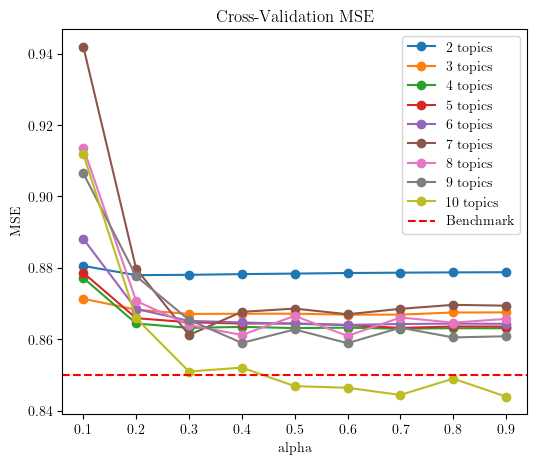

In [7]:
model.cv_mse_plot(benchmark = 0.85, figsize = (6, 5))

In [19]:
# df['Net_Wins'] = df_net_wins.Net_Wins
# df['BT_Score'] = bt_scores_all_inferred

# import embeddings 
embeddings = torch.load(data_dir / "Generated_Veganism_Arguments_Embeddings_all.pt")
embeddings.shape

embeddings_train = embeddings[df.Training_set == 1]
embeddings_test = embeddings[df.Training_set == 0]
# embeddings_train = embeddings_train[0:700,:]
print(f"{embeddings_train.shape = }")

embeddings_train.shape = torch.Size([804, 1536])


In [20]:
# show mean score by Origin_and_Prompt group 
print(f"{df[df.Origin_and_Prompt == 'Manual Collection - convincing'].BT_Score.mean() = }")
print(f"{df[df.Origin_and_Prompt == 'Manual Collection - less convincing'].BT_Score.mean() = }")
print(f"{df[df.Origin_and_Prompt == 'GPT only'].BT_Score.mean() = } \n")

print(f"{df[df.Origin_and_Prompt == 'Manual Collection - convincing'].BT_Score_01.mean() = }")
print(f"{df[df.Origin_and_Prompt == 'Manual Collection - less convincing'].BT_Score_01.mean() = }")
print(f"{df[df.Origin_and_Prompt == 'GPT only'].BT_Score_01.mean() = } \n")

# print(f"{df[df.Origin_and_Prompt == 'Manual Collection - convincing'].Score_09.mean() = }")
# print(f"{df[df.Origin_and_Prompt == 'Manual Collection - less convincing'].Score_09.mean() = }")
# print(f"{df[df.Origin_and_Prompt == 'GPT only'].Score_09.mean() = } \n")

print(f"{df[df.Origin_and_Prompt == 'Manual Collection - convincing'].Net_Wins.mean() = }")
print(f"{df[df.Origin_and_Prompt == 'Manual Collection - less convincing'].Net_Wins.mean() = }")
print(f"{df[df.Origin_and_Prompt == 'GPT only'].Net_Wins.mean() = }")

df[df.Origin_and_Prompt == 'Manual Collection - convincing'].BT_Score.mean() = 1.02960112715376
df[df.Origin_and_Prompt == 'Manual Collection - less convincing'].BT_Score.mean() = 0.9556495575640463
df[df.Origin_and_Prompt == 'GPT only'].BT_Score.mean() = 1.1738390962824408 

df[df.Origin_and_Prompt == 'Manual Collection - convincing'].BT_Score_01.mean() = 1.0012054806385868
df[df.Origin_and_Prompt == 'Manual Collection - less convincing'].BT_Score_01.mean() = 0.9909022736545706
df[df.Origin_and_Prompt == 'GPT only'].BT_Score_01.mean() = 1.0186861731731316 

df[df.Origin_and_Prompt == 'Manual Collection - convincing'].Net_Wins.mean() = 0.10752688172043011
df[df.Origin_and_Prompt == 'Manual Collection - less convincing'].Net_Wins.mean() = -1.200716845878136
df[df.Origin_and_Prompt == 'GPT only'].Net_Wins.mean() = 2.35


In [21]:
# Y = df.Score_opt[df.Training_set == 1]
# Y = df.Score[df.Training_set == 1]
# Y = df.Score_09[df.Training_set == 1]
# Y = df.Score_001[df.Training_set == 1]
# Y = df.BT_Score_01[df.Training_set == 1]
Y = df.BT_Score[df.Training_set == 1]
Y = Y.to_numpy()
X = np.array(embeddings_train)
print(f" X max: {np.max(X):.4f}, min: {np.min(X):.4f}, mean: {np.mean(X):.4f}, sd: {np.std(X):.4f}")
print(f" Y max: {np.max(Y):.4f}, min: {np.min(Y):.4f} mean: {np.mean(Y):.4f}, sd: {np.std(Y):.4f}")

# X_norm = (X - np.mean(X, axis=0))/(np.std(X,axis=0)+10**(-10))
X_norm = (X - np.mean(X, axis=0))/(np.std(X,axis=0))
Y_norm = (Y - np.mean(Y))/(np.std(Y))
print(f" X_norm max: {np.max(X_norm):.4f}, min: {np.min(X_norm):.4f}, \
mean: {np.mean(X_norm):.4f}, sd: {np.std(X_norm):.4f}")

print(f" Y_norm max: {np.max(Y_norm):.4f}, min: {np.min(Y_norm):.4f},\
 mean: {np.mean(Y_norm):.4f}, sd: {np.std(Y_norm):.4f}")

# Scale down the high-dimensional embedding to avoid dominance 
X_norm_scaled = X_norm/(X_norm.shape[1]**0.1)
print(f" X_norm_scaled max: {np.max(X_norm_scaled):.4f}, min: {np.min(X_norm_scaled):.4f}, \
mean: {np.mean(X_norm_scaled):.4f}, sd: {np.std(X_norm_scaled):.4f}")

print(f'{X.shape =}, Y.shape = {Y.shape}')

 X max: 0.2387, min: -0.6837, mean: -0.0007, sd: 0.0255
 Y max: 2.2558, min: 0.4706 mean: 1.0315, sd: 0.2625
 X_norm max: 4.8121, min: -5.1121, mean: 0.0000, sd: 1.0000
 Y_norm max: 4.6644, min: -2.1372, mean: -0.0000, sd: 1.0000
 X_norm_scaled max: 2.3104, min: -2.4545, mean: 0.0000, sd: 0.4801
X.shape =(804, 1536), Y.shape = (804,)


In [22]:
model = suntopic(Y_norm, X_norm_scaled, alpha = 0.5, num_bases = 10, random_state = 0)

In [23]:
model = suntopic(Y_norm, X_norm_scaled, alpha = 0.5, num_bases = 10, random_state = 0)
model.hyperparam_cv(alpha_range = alpha_range, num_bases_range = num_bases_range, cv_folds= 10,
    random_state = 0, niter = 100, parallel=True)

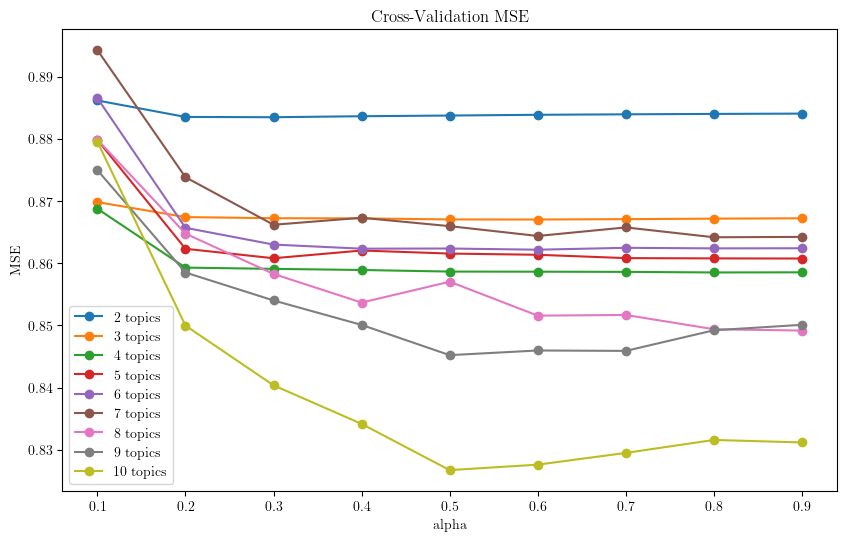

In [24]:
model.cv_mse_plot()

In [3]:
np.random.seed(44)
# Generate a random matrix X 
X = np.random.randn(3, 50)
snmf_test = SNMF(X, num_bases=2, random_state=44, legacy_mode=True)
snmf_test.factorize(niter=2, show_progress=True)

2024-04-03 12:13:44,045 [INFO] SNMF - Initial Assignment: [0 1 1]
2024-04-03 12:13:44,046 [INFO] FN: 6.977439325329257 (1 / 2)
2024-04-03 12:13:44,047 [INFO] FN: 6.929638965422419 (2 / 2)


In [4]:
snmf_test = SNMF(X, num_bases=2, random_state=44, legacy_mode=True)
snmf_test.factorize(niter=2, show_progress=True)

2024-04-03 12:13:53,887 [INFO] SNMF - Initial Assignment: [0 1 1]
2024-04-03 12:13:53,887 [INFO] FN: 6.977439325329257 (1 / 2)
2024-04-03 12:13:53,888 [INFO] FN: 6.929638965422419 (2 / 2)


In [5]:
np.random.seed(44)
# Generate a random matrix X 
X = np.random.randn(3, 50)
snmf_test = SNMF(X, num_bases=2, random_state=44, legacy_mode=True)
snmf_test.factorize(niter=20, show_progress=False)
H_test = snmf_test.H
W_test = snmf_test.W

print(X)
print(W_test.shape)
print(W_test)
print(H_test)

[[-7.50614717e-01  1.31635732e+00  1.24614003e+00 -1.60491574e+00
  -1.46814368e+00 -1.71507046e+00  1.85878369e+00  8.75879763e-02
  -5.23221964e-02  5.55471637e-01 -9.63403694e-01 -1.80321465e-01
  -1.18340916e+00  6.05445921e-01 -9.51650553e-01  3.60856060e-01
   1.06061026e+00 -1.17152178e-01  8.25664851e-01 -1.20981355e+00
  -1.19050362e+00  2.19871821e-01 -2.12919130e-01 -1.41149914e+00
  -4.82981016e-01  1.20176208e+00 -7.05803033e-01  2.51813547e-02
  -3.91128155e-01  1.93139124e-01  3.49290932e-01  5.91188382e-01
   5.20409870e-01  8.25222389e-01  4.26203507e-01  1.95640026e-01
  -5.14112178e-01 -3.07368882e+00 -3.95159070e-01 -7.95399184e-01
  -7.03201512e-01 -1.73739268e+00  7.50808258e-01 -1.86395314e+00
   4.18510984e-01 -2.35333837e-01  4.32107174e-01  8.70291930e-01
   2.00862219e+00  1.37177091e+00]
 [ 1.05859789e+00  1.44533756e+00  4.88232904e-02  9.03295203e-02
  -4.80256813e-01  3.00662736e-01  1.11297983e+00 -1.93150462e-02
  -8.07598399e-04 -6.38530234e-01  1.5946

In [6]:
print(W_test.shape)
print(W_test)
print(H_test)

(3, 2)
[[1.17797732 0.2087255 ]
 [0.34645526 0.84559617]
 [0.14539624 1.46598459]]
[[-0.80267244  1.36060009  0.90024422 -1.28755122 -1.41040407 -1.40454204
   1.75164169 -0.07776795  0.40059172  0.47474941 -0.65515775 -0.20559119
  -0.83270751  0.83826749 -0.8058675   0.3466136   0.80567418 -0.21366554
   0.83469297 -1.20397126 -1.22763569  0.30613543  0.05494692 -1.36912669
  -0.86629273  1.31277382 -0.73805959  0.13504014 -0.30046357 -0.48583546
   0.26397705  0.41342366  0.53045239  0.92354565  0.11736057 -0.23933129
  -0.69279653 -2.37885053 -0.22428498 -0.81647817 -0.74429769 -1.32292411
   0.55264664 -1.68885933  0.34056615 -0.16078402  0.42005637  0.7640741
   1.8728926   1.17709454]
 [ 1.24297945 -0.16167407  0.31355534  0.08413558  0.48627001  0.29518286
  -0.2229733   0.45078035 -1.3851298  -0.4643786   0.55468435  0.20502201
  -0.02297159 -1.22876441  0.41476171 -1.21695439  0.19508302  0.02750018
   0.18477192  1.19522359  0.71909032 -0.82094456 -1.23700905  1.08852179
   

In [14]:
np.random.seed(44)
# Generate a random matrix X 
X = np.random.randn(3, 50)
snmf_test = SNMF(X, num_bases=2, random_state=44, legacy_mode=True)
snmf_test.factorize(niter=20, show_progress=False)
H_test = snmf_test.H
W_test = snmf_test.W

print(X)
print(W_test.shape)
print(W_test)
print(H_test)

Assign: [0 1 1]
H1: [[1.52 0.72]
 [0.72 2.92]] 
 H2: [[-3.79172008e-01  1.73962094e+00  1.68100032e+00 -1.97150936e+00
  -1.71235220e+00 -2.01106834e+00  2.36292594e+00  2.71948624e-01
  -5.70084607e-01  4.61363216e-01 -8.41362757e-01 -1.49418736e-01
  -1.43377236e+00  2.90903440e-01 -9.94002210e-01 -1.78080266e-01
   1.41398420e+00 -2.00301398e-01  1.23668978e+00 -1.00117009e+00
  -1.25901261e+00 -9.78832212e-02 -8.14390340e-01 -1.31483406e+00
  -2.69953001e-01  1.62585272e+00 -1.00859940e+00 -3.04023254e-01
  -8.15065329e-01  5.20160442e-01  5.74447002e-01  5.55301253e-01
   8.77528374e-01  7.39712344e-01  2.00454578e-01  4.28140366e-01
  -3.38505490e-01 -3.54784737e+00 -7.63029738e-01 -8.91433477e-01
  -1.15171695e+00 -1.86850089e+00  2.93910448e-01 -2.03317426e+00
   4.98841178e-01 -2.38177531e-01  6.39755345e-01  1.32674228e+00
   2.20639116e+00  1.07948270e+00]
 [ 2.97927097e+00  1.22322436e+00  1.36302175e+00 -5.94645968e-01
   2.89257694e-03 -6.09168210e-02  1.16606978e+00  1.0

In [16]:

print(W_test.shape)
print(W_test)
print(H_test)

(3, 2)
[[1.17797732 0.2087255 ]
 [0.34645526 0.84559617]
 [0.14539624 1.46598459]]
[[-0.80267244  1.36060009  0.90024422 -1.28755122 -1.41040407 -1.40454204
   1.75164169 -0.07776795  0.40059172  0.47474941 -0.65515775 -0.20559119
  -0.83270751  0.83826749 -0.8058675   0.3466136   0.80567418 -0.21366554
   0.83469297 -1.20397126 -1.22763569  0.30613543  0.05494692 -1.36912669
  -0.86629273  1.31277382 -0.73805959  0.13504014 -0.30046357 -0.48583546
   0.26397705  0.41342366  0.53045239  0.92354565  0.11736057 -0.23933129
  -0.69279653 -2.37885053 -0.22428498 -0.81647817 -0.74429769 -1.32292411
   0.55264664 -1.68885933  0.34056615 -0.16078402  0.42005637  0.7640741
   1.8728926   1.17709454]
 [ 1.24297945 -0.16167407  0.31355534  0.08413558  0.48627001  0.29518286
  -0.2229733   0.45078035 -1.3851298  -0.4643786   0.55468435  0.20502201
  -0.02297159 -1.22876441  0.41476171 -1.21695439  0.19508302  0.02750018
   0.18477192  1.19522359  0.71909032 -0.82094456 -1.23700905  1.08852179
   

In [10]:
np.random.seed(44)
# Generate a random matrix X 
X = np.random.randn(3, 5)
snmf_test = SNMF(X, num_bases=2, random_state=44, legacy_mode=False)
snmf_test.factorize(niter=1, show_progress=False)
H_test = snmf_test.H
W_test = snmf_test.W

print(X)
print(W_test.shape)
print(W_test)
print(H_test)

Assign: [0 1 1]
H1: [[1.52 0.72]
 [0.72 2.92]] 
 H2: [[-1.43643249  1.91532123  1.2762038  -1.81527414 -1.8410082 ]
 [-3.36429193  2.27742614 -1.06575741  0.34276532 -0.76904344]] 

W1: [[7.26156694 0.5343712 ]
 [2.67528366 2.80252752]
 [0.5343712  2.00662743]] 
 W2: [[7.26156694 0.53437121]
 [1.21026116 2.40457748]
 [1.99939371 2.40457748]]
[[-0.75061472  1.31635732  1.24614003 -1.60491574 -1.46814368]
 [-1.71507046  1.85878369  0.08758798 -0.0523222   0.55547164]
 [-0.96340369 -0.18032147 -1.18340916  0.60544592 -0.95165055]]
(3, 2)
[[1.2        0.2       ]
 [0.29735508 1.29549816]
 [0.10339567 1.09621371]]
[[-0.45206446  1.00841612  1.14639297 -1.4151509  -1.23011037]
 [-1.04068682  0.53128991 -0.64765765  0.4663267   0.03994385]]


In [11]:
model.hyperparam_cv(alpha_range = alpha_range, num_bases_range = num_bases_range, cv_folds= 10,
    random_state = 0, niter = 100, parallel=True)